In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr)
library(dplyr); library(tidyr)
library(ggplot2)
library(rwantshue)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [13]:
%%R
physeq = import_biom("../../SeqData/TaxonomySH/ITS.otu_table.tax.meta.biom", parseFunction = parse_taxonomy_greengenes)

In [14]:
%%R
Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [15]:
%%R
mdf = psmelt(physeq)

###Phylogenetic overview

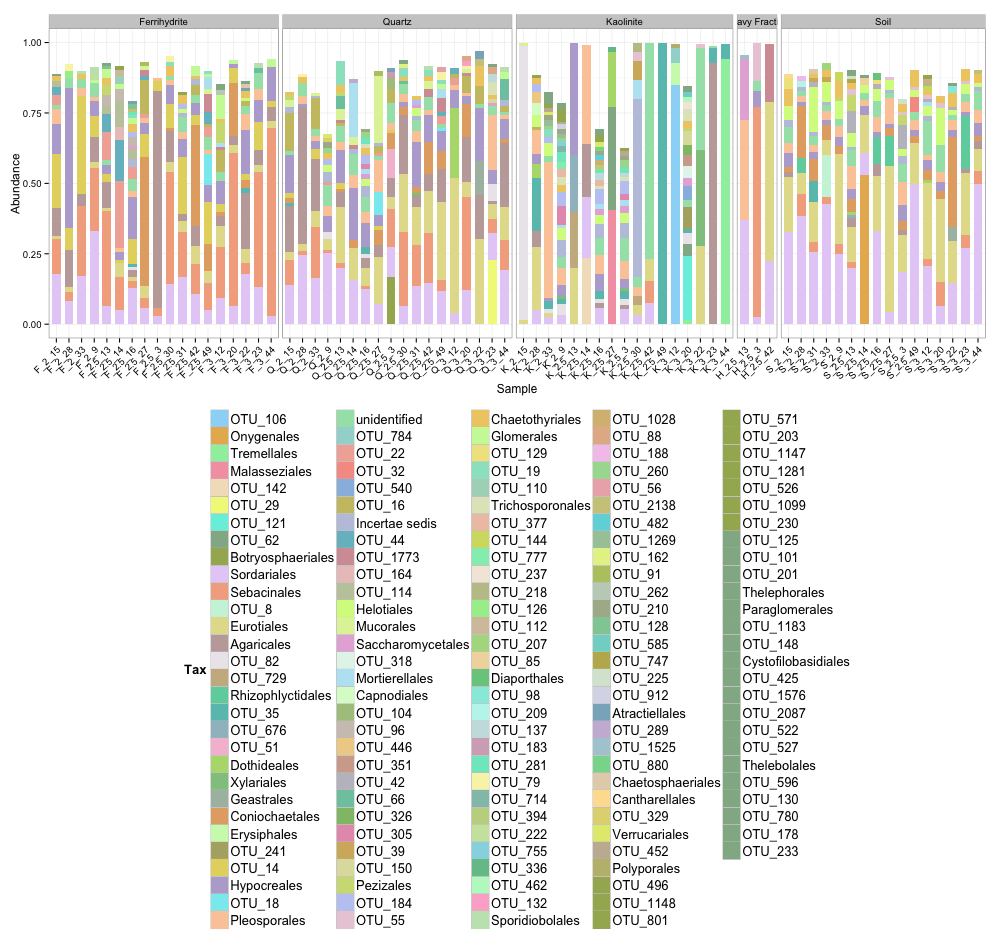

In [21]:
%%R -w 1000 -h 950

cutoff = 0.01
totabund = 1

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, d.plot$OTU, paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Sample, Order, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
#    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.text.x = element_text(angle=45, hjust=1), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

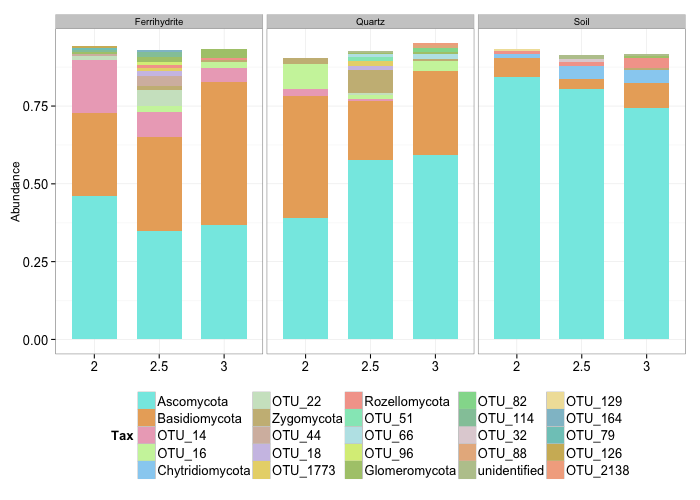

In [25]:
%%R -w 700 -h 500

cutoff = 0.005
totabund = 3000

d.plot = mdf %>%
    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Phylum = ifelse(is.na(d.plot$Phylum)==TRUE, d.plot$OTU, paste(d.plot$Phylum))
d.plot = d.plot %>%
    group_by(Trtmt,Month, Phylum, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Phylum) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Trtmt", "Month", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))
d.plot$Month = as.factor(d.plot$Month)

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Month, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=13), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

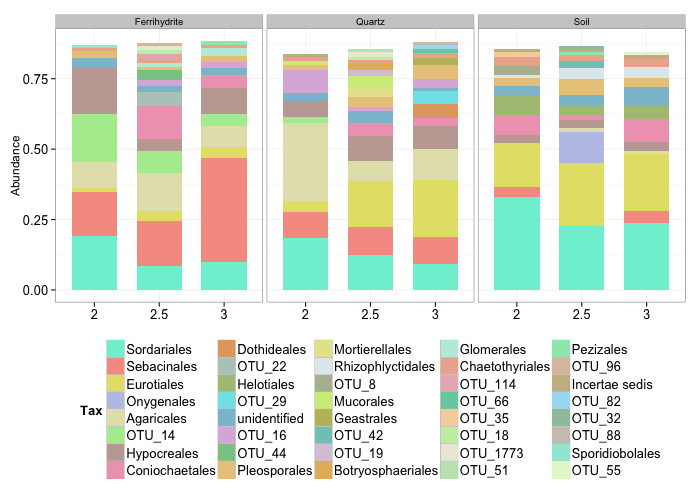

In [17]:
%%R -w 700 -h 500

cutoff = 0.01
totabund = 3000

d.plot = mdf %>%
    filter(Trtmt != "Kaolinite") %>%
    group_by(Sample) %>%
    filter(sum(Abundance) > totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance))
d.plot$Order = ifelse(is.na(d.plot$Order)==TRUE, d.plot$OTU, paste(d.plot$Order))
d.plot = d.plot %>%
    group_by(Trtmt,Month, Order, OTU) %>%
    summarize(Abundance = mean(Abundance)) %>%
    group_by(Trtmt, Month, Order) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Trtmt", "Month", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))
d.plot$Month = as.factor(d.plot$Month)

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Month, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    axis.title.x = element_blank(), axis.text = element_text(size=13), 
    legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

This shows the relative abundance of each taxon, out of the total pool in each sample.  
We can see that Glomerales are relatively enriched compared to the soil.  
Onygenales in Soil could be contamination or perhaps sheep droppings?  Matches Emmonsia, which is a saptrotroph, and can live in the soil.  
OTU_14 matches Dothideomycetes or another Ascomycete at 89%

In [405]:
%%R
#tax = data.frame(tax_table(physeq))
#tax.na = row.names(tax[is.na(tax$Kingdom)==TRUE,])
#length(tax.na)
# There are 1005/2200 OTUs that we could not match in the UNITE db
physeq.na = subset_taxa(physeq, is.na(Kingdom) == TRUE)
otu_table(physeq.na)

OTU Table:          [1005 taxa and 73 samples]
                     taxa are columns
         OTU_64 OTU_2138 OTU_66 OTU_187 OTU_32 OTU_584 OTU_22 OTU_14 OTU_38
B__           0        0      0       0      0       0      0      0      0
F_2_15        0        1    168       0      0       0    692   3512    361
F_2_28       10        0     18       2      0       0     56   2549     58
F_2_33        7        1      0       0      0       0      0   4782    173
F_2_9         0        0      0       0      0       0      0    860      9
F_2.5_13      0        0      0       0      0       0   3405   1000    349
F_2.5_14      0        1      4       0      0       0  10673    510     68
F_2.5_16      1       34      0       0      0       0    125    269      7
F_2.5_27      1        1      1       0      0       0    924   5180    520
F_2.5_3       0        0      0       0      0       0     39    190      6
F_2.5_30      0        0      0       0      0       0      0   2389      0
F_2

###Looking at all OTUs

Error in eval(expr, envir, enclos) : object 'Cosm' not found


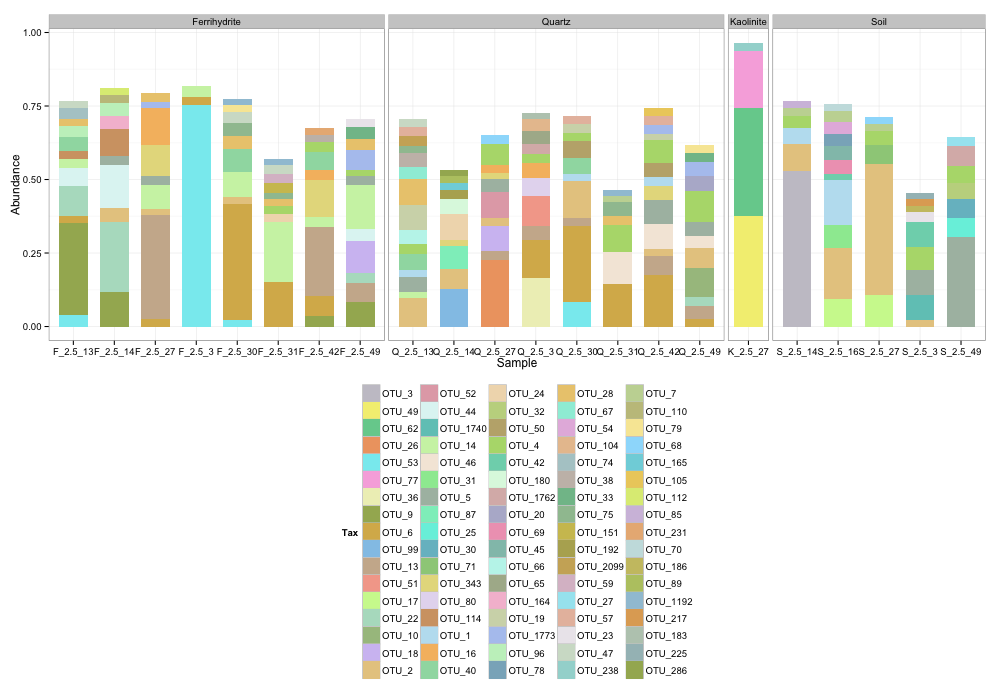

In [373]:
%%R -w 1000 -h 700

cutoff = 0.02
totabund = 3000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Abundance = Abundance / sum(Abundance)) %>%
    group_by(Sample, OTU, Trtmt, Month) %>%
    summarize(Abundance = sum(Abundance)) %>%
    filter(Abundance > cutoff) %>%
    filter(Month == 2.5) %>%
#    filter(Trtmt != "Kaolinite") %>%
    arrange(Trtmt)

colnames(d.plot) <- c("Sample", "Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))
#d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("F", "Q", "K", "H", "S"))


d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Sample, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Sample, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 5))

p = p + theme_bw()

p = p + theme(
    #axis.text.x = element_blank(), 
    legend.position="bottom")

p

In [45]:
%%R -w 1000 -h 700

cutoff = 0.001
totabund = 3000

d.plot = mdf %>%
    filter(Sample == 70) %>%
    mutate(Relabund = Abundance / sum(Abundance)) %>%
    arrange(-Relabund)
d.plot[complete.cases(d.plot[,1:3]),c(1:3,21)]
#Looking at most abundant OTUs in sample 70, which has many not ID'd even to phylum.

          OTU Sample Abundance     Relabund
1      OTU_22     70     10581 2.470753e-01
2      OTU_44     70      6487 1.514769e-01
3       OTU_9     70      5286 1.234326e-01
4     OTU_114     70      4058 9.475773e-02
5      OTU_96     70      2045 4.775248e-02
6     OTU_164     70      2024 4.726211e-02
7       OTU_2     70      1845 4.308231e-02
8       OTU_5     70      1265 2.953882e-02
9     OTU_110     70      1151 2.687682e-02
10    OTU_112     70      1052 2.456509e-02
11     OTU_28     70       761 1.776999e-02
12    OTU_230     70       556 1.298307e-02
13      OTU_1     70       518 1.209574e-02
14     OTU_14     70       438 1.022767e-02
15     OTU_52     70       413 9.643900e-03
16     OTU_18     70       348 8.126095e-03
17    OTU_674     70       346 8.079393e-03
18    OTU_889     70       272 6.351430e-03
19    OTU_565     70       252 5.884413e-03
20   OTU_1773     70       226 5.277291e-03
21     OTU_10     70       173 4.039696e-03
22     OTU_40     70       163 3

OTU_22, OTU_44, OTU_96, OTU_114, OTU_112, OTU_110, OTU_164 does match an uncultured fungus clone ITS2 (OTU2087) from tallgrass prairie soil  (60% of total)  
Blasting OTU_22 full sequence gives same match, and possible match of sub(phylum)division Mucoromycotina - not yet clearly placed in the fungal tree. Not much hope of matching it, but at least it doesn't seem like a clear error or contamination. Includes saprobes, plant pathogens, and mycoparasites.  
OTU_9 matches Sebacinales  
OTU_2 matches Tallaromyces cellulolyticus or pinophilis  
OTU_103 matches an uncultured EMF clone G2_CH3 from Topanga state park grassland soil (near LA)

In [39]:
!grep -A -3 OTU_263 ../../SeqData/ITS.otus.fasta

>OTU_263
AAATAAAAATCGAGGTTTTTGCTGCCTTTTCGTGGTGAAGCTTCGGAGTTGGGTCGTCTTTACCTTTCGGTTAAGTGACC
TAAAATTTTTGTATGATATCTGAACGTATTTAAATTTATTTGGTACGTTTTGTAATATCAAATGTTTATTAGGTGTGGTC
ATCCTTATGATTCACGTCTATAATTTTTCATC
>OTU_264
CAAACCTCAAGCTTCTGCTTGGTATTGGGCCTCGTCCGTCTAGGACGTGCCAGAAACCCGTGGGCGGTGGTGCCGGTCTC
CCAGCGTAGTCAATTCTATCCGCTTCGGAGCCTCAGGTGCTGCCCGCCGGACAACTCCAAATTTTTCTATG
>OTU_265
AATTCTCAACCTCACCCATTTTGTCATGAAGTGGTTTGTGTAGGCTTGGATGTGGGGGCTTGCAGGTCCGACCTTGTGGT
TGGTCTGCTCCTCTGAAATGCATTAGTGGGTTTTGCCCCTAATCTATTGGTGTGATAATTATCTACGCCGTGGATCAGGA
TTGGCGATCAATGACCTGCTGATAACCCGTCCGTCTCGGACAACTTGACAT
>OTU_266
GTACCCTCCAGCCCTGCTGGGTGTTGGGCGTTTTGTTCCGCTGCGCGCGTGAACTCGCCTCAAATGCATTGGCAGCCCGC
CGTCCTGTGTGGGAGCGCAGCACATTTTGCGCTCTCCACTGCTGACGGTGGCATCCACAAGTCTACCATTTTAC
>OTU_267
CTGCCCTCCAGCCCGGCTGGTGTGTTGGGCCCCGTCCCCCTTCCCGGGGGGACGGGCCCGAAAGGCAGCGGCGGCACCGC
GTCCGGTCCTCGAGCGTATGGGGCTTTGTCACCCGCTCTTGTAGGCCCGGCCGGCGTCAGCCGACCCCCTCAATCTATTT
TTTCA
>OTU_268
CTGCCCATCAAGCGCGGCTTGTGTGTTGGGCCGCCGTCCCGCCCCCCGGGGAGGGACGGG

In [52]:
!grep "AAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTG" \
../../SeqData/pear_merged_2015_07_13.assembled.demult.maxee.unique.good.fasta

CAGTGAATCATCGAATCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGGGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTGTTTAGATCTGAAATCAGGTGGGACTACCCGCTGAACTTAAGCATATCAATAACGGAGGATCTTA
CAGTGAATCATCGAGTCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGAGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTTTAATCTCTGGCTCAATAAATATGGAAAAATGAAATATTTATATATTTCATCATTGTTTAGATCTGAAATCAGGTGGGACTACCCGCTGAACTTAAGCATATCAATAAGCGGAGGATCTTA
CAGTGAATCATCGAATCTTTGAACGCATATTGCACTCTCTGGTATTCCGGAGAGTACACCTGTTTCAGTATCAAAAATGTCTTCCAAAGTTTTGCTTTGTTTGTTAACCAGATAGGTCAAAACTTATGGGATTTGGGTTTTGCAGAACGTTTCGTTCGGCTGGCCTTAAATTATTTTAGCCATAAAAAGTTCTCGGATAAGGCGTAATAGTTGGTACCTTTGGGTCCATCCCTTTCGCTGAAGCCAATCTTTT

###Looking at Glomeromycota only

First making sure the arrangements are correct

In [231]:
%%R
fakeOTUtable = read.csv("../../SeqData/FakeOTUtable.csv")
head(fakeOTUtable)

  Taxon  Phylum Sample Trtmt Month Abundance
1     1    Bigs      A     Q   2.5        45
2     2    Bigs      A     Q   2.5        23
3     3    Bigs      A     Q   2.5        14
4     4    Bigs      A     Q   2.5         2
5     5 Littles      A     Q   2.5        46
6     6 Littles      A     Q   2.5         0


In [242]:
%%R

totabund=120

d.plot = fakeOTUtable %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund)%>%
    mutate(abund.insample=Abundance / sum(Abundance))%>%
    group_by(Taxon,Trtmt,Month,Phylum)%>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Phylum,Trtmt,Month)%>%
    summarize(phylabund = sum(mean.relabund))
d.plot[]

Source: local data frame [8 x 4]
Groups: Phylum, Trtmt

   Phylum Trtmt Month phylabund
1    Bigs     F   2.5 0.3613360
2    Bigs     F   3.0 0.4582729
3    Bigs     Q   2.5 0.3346614
4    Bigs     Q   3.0 0.3408492
5 Littles     F   2.5 0.6386640
6 Littles     F   3.0 0.5417271
7 Littles     Q   2.5 0.6653386
8 Littles     Q   3.0 0.6591508


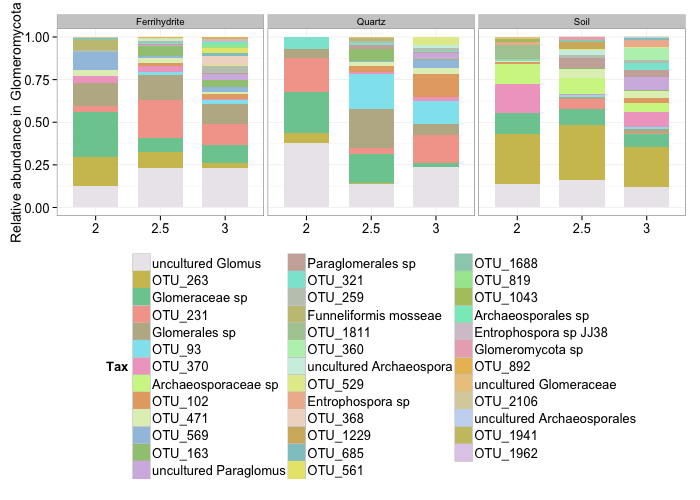

In [38]:
%%R -w 700 -h 500

totabund = 2000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    filter(Phylum=="Glomeromycota")%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
#    filter(Month == 2.5) %>%
    filter(sum(Abundance)>0)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, d.plot$OTU, paste(d.plot$Species))
d.plot = d.plot %>%
    mutate(abund.insample = Abundance / sum(Abundance))%>%
    group_by(OTU,Trtmt,Month,Species) %>%
    summarize(mean.relabund = mean(abund.insample))%>%
    group_by(Trtmt,Month,Species) %>%
    summarize(relabund=sum(mean.relabund))

colnames(d.plot) <- c("Trtmt", "Month", "Tax", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance
d.plot$Month = factor(d.plot$Month)

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Month, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Trtmt, scales = "free_x", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + guides(fill = guide_legend(ncol = 3))

p = p + theme_bw() + labs(y="Relative abundance in Glomeromycota")

p = p + theme(axis.text = element_text(size=13), axis.title.x = element_blank(), 
              axis.title.y = element_text(size=14),
                  legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p

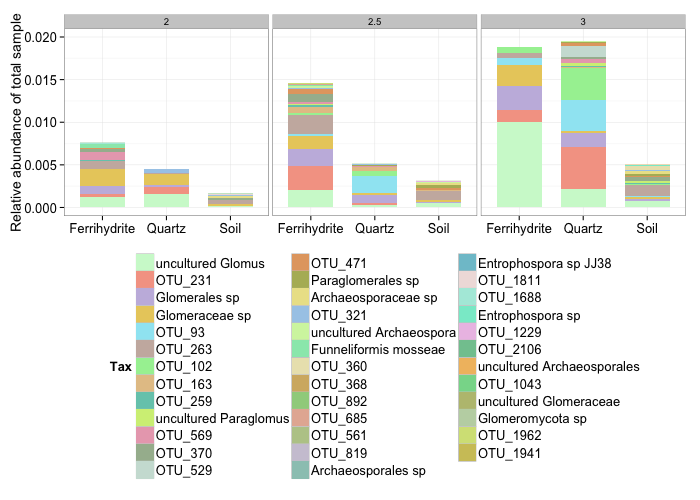

In [35]:
%%R -w 700 -h 500

totabund = 2000

d.plot = mdf %>%
    group_by(Sample) %>%
    filter(sum(Abundance)>totabund) %>%
    mutate(Total=sum(Abundance))%>%
    filter(Phylum=="Glomeromycota")%>%
    filter(sum(Abundance)>0)%>%
    filter(Trtmt != "Kaolinite" & Trtmt != "Heavy Fraction") %>%
    mutate(relabund = Abundance / Total)
d.plot$Species = ifelse(is.na(d.plot$Species)==TRUE, d.plot$OTU, paste(d.plot$Species))
d.plot = d.plot %>%
    group_by(Sample,Species,Trtmt,Month) %>%
    summarize(relabund=sum(relabund)) %>%
    group_by(Species,Trtmt,Month)%>%
    summarize(relabund=mean(relabund)) %>%
    arrange(Trtmt,Month)

colnames(d.plot) <- c("Tax", "Trtmt", "Month", "Abundance")

mean.Abund = ddply(d.plot, .(Tax), summarize, M = mean(Abundance))
# Calculate the phyla's mean abundances
d.plot$Tax = factor(d.plot$Tax, levels=mean.Abund[order(-mean.Abund$M),]$Tax)
# Order the Phyla by abundance

d.plot$Trtmt = ordered(d.plot$Trtmt, levels = c("Ferrihydrite", "Quartz", "Kaolinite", "Heavy Fraction", "Soil"))

d.plot<-d.plot[with(d.plot, order(Month, Trtmt, Tax)),]
# Sort the whole dataframe by this phylum order

scheme <- iwanthue()
colors = scheme$hex(length(unique(d.plot$Tax)), color_space = hcl_presets$pastel)

p = ggplot(d.plot, aes(x = Trtmt, y = Abundance, fill = Tax))

p = p + facet_grid(. ~Month, scales = "free_y", space = "free")

p = p + scale_fill_manual(values = colors)

p = p + geom_bar(stat = "identity", width = 0.70)

p = p + ylim(0,0.02)

p = p + guides(fill = guide_legend(ncol = 3))

p = p + theme_bw() + labs(y="Relative abundance of total sample")

p = p + theme(axis.text = element_text(size=13), axis.title.x = element_blank(), 
              axis.title.y = element_text(size=14),
                  legend.position="bottom", legend.text=element_text(size=13), legend.title=element_text(size=13))

p